# Named Entity Recognition: RNN vs Pre-Trained Transformer

## Setup

In [1]:
# Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


# GloVe
import gensim.downloader

# Transformers
from transformers import AutoTokenizer, DataCollatorForTokenClassification, AutoModelForTokenClassification, TrainingArguments

# DL
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_sequence, unpack_sequence

# Hugging Face
from datasets import load_dataset, load_metric

2023-07-21 23:46:18.577737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 23:46:19.160769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1 RNN

### 1.1 Data Exploration & Analysis

In [2]:
glove_embeddings = gensim.downloader.load("glove-wiki-gigaword-300")

In [3]:
len(glove_embeddings), len(glove_embeddings[0])

(400000, 300)

In [4]:
conll2003_dataset = load_dataset("conll2003")

Found cached dataset conll2003 (/home/markkl/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
[dataset.num_rows for dataset in conll2003_dataset.values()]

[14041, 3250, 3453]

In [6]:
conll2003_dataset['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}

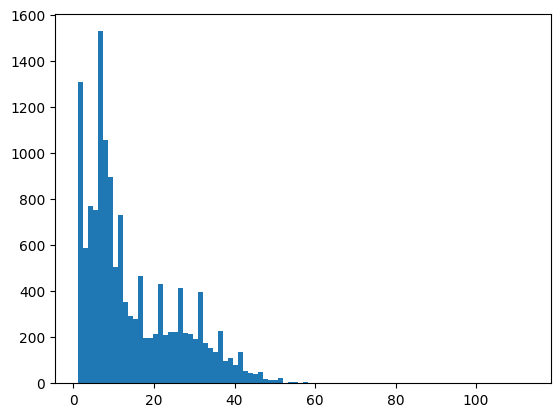

In [7]:
sentences = conll2003_dataset['train'][:]['tokens']
plt.hist([len(s) for s in sentences], bins=90)
plt.show()

In [8]:
tag2id = {tag: i for i, tag in enumerate(conll2003_dataset['train'].features['ner_tags'].feature.names)}
id2tag = {i: tag for i, tag in enumerate(conll2003_dataset['train'].features['ner_tags'].feature.names)}

tag2id, id2tag

({'O': 0,
  'B-PER': 1,
  'I-PER': 2,
  'B-ORG': 3,
  'I-ORG': 4,
  'B-LOC': 5,
  'I-LOC': 6,
  'B-MISC': 7,
  'I-MISC': 8},
 {0: 'O',
  1: 'B-PER',
  2: 'I-PER',
  3: 'B-ORG',
  4: 'I-ORG',
  5: 'B-LOC',
  6: 'I-LOC',
  7: 'B-MISC',
  8: 'I-MISC'})

In [9]:
all_tokens = []

for sequence in conll2003_dataset['train']:
    all_tokens = list(set(all_tokens + sequence['tokens']))
    
print(len(all_tokens))

all_tokens = []

for sequence in conll2003_dataset['validation']:
    all_tokens = list(set(all_tokens + sequence['tokens']))
    
print(len(all_tokens))

23623
9966


In [10]:
max_len = -1

def get_keys_from_DataSet(DS_NAME, keys = ['tokens','ner_tags']):
     return [conll2003_dataset[DS_NAME][:max_len].get(key) for key in keys]
 

# Split data
train_data, train_label = get_keys_from_DataSet('train')
val_data, val_label= get_keys_from_DataSet('validation')
test_data, test_label  = get_keys_from_DataSet('test')

### 1.2 Dataset & Dataloader

In [11]:
UNKNOWN = '<unk>'

vocab = []
for line in train_data:
  vocab += line
vocab+= [UNKNOWN]

# Create dictionaries to convert between tokens and indices
token_to_index = {tok: i for i, tok in enumerate(set(vocab))}
index_to_token = {i: tok for i, tok in enumerate(set(vocab))}

def word_to_index(word):
    if word in token_to_index:
        return token_to_index[word]
    return token_to_index[UNKNOWN]

In [12]:
class LanguageModelDataset(Dataset):
    def __init__(self, data, labels):      
        data_as_index = [list(map(word_to_index, sentence)) for sentence in data]  
        self.X = data_as_index
        self.y = labels

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def __len__(self):
        return len(self.y)

In [13]:
train_dataset = LanguageModelDataset(train_data, train_label)
val_dataset = LanguageModelDataset(val_data, val_label)
test_dataset = LanguageModelDataset(test_data, test_label)

In [14]:
def my_collate_fn(batch):
    padded_batch = pack_sequence([torch.tensor(sample[0], dtype=torch.long) for sample in batch], enforce_sorted=False)
    labels = pack_sequence([torch.tensor(sample[1], dtype=torch.long) for sample in batch], enforce_sorted=False)
    return padded_batch, labels

In [15]:
batch_size = 32

# Create a DataLoader object
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, collate_fn=my_collate_fn)

In [16]:
print(train_data[0], train_label[0])

# # print batch
# for sentence, labels in train_dataloader:
#     [print(a) for a in zip([[index_to_token[word] for word in token_ind.tolist()] for token_ind in unpack_sequence(sentence)],
#           [label.tolist() for label in unpack_sequence(labels)])]
#     break

# print('\n')

# #print whole data
# for sentence, labels in train_dataloader:
#     [print(a) for a in zip([[index_to_token[word] for word in token_ind.tolist()] for token_ind in unpack_sequence(sentence)],
#           [label.tolist() for label in unpack_sequence(labels)])]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'] [3, 0, 7, 0, 0, 0, 7, 0, 0]


### 1.3 Model 

#### 1.3.1 Definition

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_layers = 3,embedding_dim = 300,dropout = 0.1):
        super().__init__()
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=True, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(2*hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 =  nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_sequence):
        
        # Unpack the input sequence into individual tokens
        unpacked_sequence = unpack_sequence(input_sequence)

        # Execute a forward pass of the LSTMModel
        batch_size = len(unpacked_sequence)
        
        # Convert each token into an embedding vector
        embedded_sequence = [torch.tensor(np.array([self.use_glove(index_to_token[word]) for word in token.tolist()]), dtype=torch.float).cuda() for token in unpacked_sequence]
        
        # Pack the embedded sequence for variable length support
        packed_sequence = pack_sequence(embedded_sequence, enforce_sorted=False)
        # Pass the packed sequence through the LSTM layer
        lstm_output, (hidden_state, cell_state) = self.lstm(packed_sequence)
 
        # Apply dropout to the LSTM output
        unpacked_output = unpack_sequence(lstm_output)
        lstm_output_dropout = [self.dropout(tensor) for tensor in unpacked_output]

        output = []
        # unpack the LSTM output and pass it through the linear layer
        for a in unpack_sequence(lstm_output):
            output.append(self.fc2(self.relu(self.fc1(a))))
            
        # Return the final output
        return output # torch.stack(output)
      
    def use_glove(self, word):
     if word in glove_embeddings:
          return glove_embeddings[word]
     else:
          return np.zeros((300))


In [18]:
def labels_into_onehot(labels):
    res = []
    for label in labels:
        onehot = np.zeros(len(tag2id),dtype=np.float64)
        onehot[label] = 1.0
        res.append(torch.tensor(onehot,dtype=torch.float))
    return torch.stack(res)

def batch_into_onehot(batch):
    return torch.cat([labels_into_onehot(labels).clone().detach() for labels in batch]).cuda()#torch.stack([labels_into_onehot(labels) for labels in batch]).cuda()

#### 1.3.2 Experiments

In [19]:
torch.cuda.is_available()

True

In [38]:
import copy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_losses = []
val_losses = []

def train(model, lr=0.0001, num_epochs=100,patience=6):
    patience_counter = 0
    best_loss = -1
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    loss = None

    # Train the model
    for epoch in range(num_epochs):
      train_loss = 0.0
      val_loss = 0.0

      model.train()
      for inputs, targets in train_dataloader:

          inputs = inputs.to(device)
          targets = targets.to(device)
          
          # Zero the gradients and forward pass
          model.zero_grad()
          
          outputs = model(inputs)
        
          loss = criterion(torch.cat(outputs), batch_into_onehot(unpack_sequence(targets)))

          # Backward pass and optimization step
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          
      # Validation
      model.eval()
      with torch.no_grad():

        for inputs, targets in val_dataloader:

            inputs = inputs.to(device)
            targets = targets.to(device)

            # Zero the gradients and forward pass
            model.zero_grad()

            outputs = model(inputs)
            loss = criterion(torch.cat(outputs), batch_into_onehot(unpack_sequence(targets)))

            val_loss += loss.item()
        
        # Calculate average losses
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)

        # Save losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Perplexity: {np.exp(val_loss):.4f}')
        
        # Check if validation loss is increasing, and break the loop if it is
        if  epoch > 0 and val_losses[-1] >= best_loss:
            patience_counter+=1
            if patience_counter >= patience:
                print(f'Best Epoch number {epoch-patience+1} :: Val Loss: {best_loss:.4f}, Perplexity: {np.exp(best_loss):.4f}')
                return best_model
        else:
            best_model = copy.deepcopy(model)
            
            patience_counter = 0
            best_loss = val_losses[-1]
            
    return best_model            
            
tag_vocab_size = len(tag2id)
hidden_dim = 100

# # Create the model and train it
model = LSTMModel(tag_vocab_size,  hidden_dim)


model = train(model)

Epoch 1/100, Train Loss: 0.8498, Val Loss: 0.5292, Perplexity: 1.6975
Epoch 2/100, Train Loss: 0.4552, Val Loss: 0.4225, Perplexity: 1.5258
Epoch 3/100, Train Loss: 0.3591, Val Loss: 0.3778, Perplexity: 1.4590
Epoch 4/100, Train Loss: 0.3212, Val Loss: 0.3713, Perplexity: 1.4496
Epoch 5/100, Train Loss: 0.2953, Val Loss: 0.3360, Perplexity: 1.3994


KeyboardInterrupt: 

#### 1.3.3 Evaluation

In [44]:
model.lstm.flatten_parameters()
model.eval()
count = 0
i = 0
for inputs, targets in test_dataloader:

      inputs = inputs.to(device)
      targets = targets.to(device)

      # Zero the gradients and forward pass
      model.zero_grad()

      outputs = model(inputs)
      for c,e in enumerate(outputs):
          tst = nn.Softmax(dim=1)(e)
          o = torch.argmax(torch.where(tst>0.42, tst, 0), axis=1)
          u = unpack_sequence(targets)[c]
          count += torch.sum(u==o).item()
          i+=u.size().numel()
print(count/i)

0.8867310428072596


## 2 Pre-Trained

In [53]:
conll2003_dataset = load_dataset("conll2003")

Found cached dataset conll2003 (/home/markkl/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

In [54]:
label_list = conll2003_dataset["train"].features[f"ner_tags"].feature.names
id2tag = {id: tag for id, tag in enumerate(label_list)}
id2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}

In [55]:
data_len = 1000

train_dataset = conll2003_dataset["train"].select(range(data_len))
train_dataset

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 1000
})

### 2.1 Dataset & Dataloader

In [56]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [57]:
tokenized_input = tokenizer(conll2003_dataset["train"][2]["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [58]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [59]:
tokenized_conll2003 = conll2003_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)

Loading cached processed dataset at /home/markkl/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-0406a691f1b72d72.arrow
Loading cached processed dataset at /home/markkl/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-ef7bd1f5d4137b64.arrow
Loading cached processed dataset at /home/markkl/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-1c4e3111aac637e4.arrow
Loading cached processed dataset at /home/markkl/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-3e54e5f831c47244.arrow


In [60]:
id2tag[-100]='ignore'
exml=tokenized_train_dataset[2]

pd.DataFrame({'tokens':tokenizer.convert_ids_to_tokens(exml["input_ids"]), 'ner_labels':exml['labels'], 'ner_tags': [id2tag[label] for label in exml['labels']] })

,tokens,ner_labels,ner_tags
0,[CLS],-100,ignore
1,brussels,5,B-LOC
2,1996,0,O
3,-,-100,ignore
4,08,-100,ignore
5,-,-100,ignore
6,22,-100,ignore
7,[SEP],-100,ignore


### 2.2 Fine-Tuning

In [61]:
#Data Collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
metric_seqeval = evaluate.load("seqeval")
example = conll2003_dataset["train"][2]

labels = [label_list[i] for i in example["ner_tags"]]
metric_seqeval.compute(predictions=[labels], references=[labels])

{'LOC': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [63]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric_seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [64]:
from transformers import EarlyStoppingCallback, Trainer

training_args = TrainingArguments(
    output_dir='./log_results',
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=16,   
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    warmup_steps=500, 
    eval_steps=60,
    save_steps=60,
    evaluation_strategy="steps",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_conll2003["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 6)]
)

trainer.train()

/home/markkl/.conda/envs/tf_gpu/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
60,No log,1.684403,0.020349,0.021205,0.020768,0.728340
120,No log,0.608373,0.361277,0.030461,0.056185,0.842218
180,No log,0.289739,0.540595,0.587176,0.562924,0.924399
240,No log,0.193698,0.629037,0.708011,0.666192,0.946264
300,No log,0.144892,0.734738,0.798048,0.765086,0.961489


/home/markkl/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=315, training_loss=0.7791654556516617, metrics={'train_runtime': 34.3067, 'train_samples_per_second': 145.744, 'train_steps_per_second': 9.182, 'total_flos': 109081967876928.0, 'train_loss': 0.7791654556516617, 'epoch': 5.0})

#### 2.3 Comparison to RNN

In [65]:
predictions, labels, _ = trainer.predict(tokenized_conll2003["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric_seqeval.compute(predictions=true_predictions, references=true_labels)
results

{'LOC': {'precision': 0.7112831858407079,
  'recall': 0.7709832134292566,
  'f1': 0.7399309551208285,
  'number': 1668},
 'MISC': {'precision': 0.4727932285368803,
  'recall': 0.5569800569800569,
  'f1': 0.5114453891432308,
  'number': 702},
 'ORG': {'precision': 0.6281329923273657,
  'recall': 0.7393136664659844,
  'f1': 0.6792035398230089,
  'number': 1661},
 'PER': {'precision': 0.9367959949937422,
  'recall': 0.9257884972170687,
  'f1': 0.9312597200622086,
  'number': 1617},
 'overall_precision': 0.711376858435682,
 'overall_recall': 0.7793909348441926,
 'overall_f1': 0.7438323758026361,
 'overall_accuracy': 0.9560891568859696}

#### 2.3.1 Setups

#### 2.3.2 Approaches

#### 2.3.3 Error Analysis

## 3 Conclusions